<!--HEADER-->
*[Guia de aulas da disciplina de Modelagem Matemática](https://github.com/rmsrosa/modelagem_matematica) do [IM-UFRJ](https://www.im.ufrj.br).*

<!--NAVIGATOR-->

<a href="https://colab.research.google.com/github/rmsrosa/modelagem_matematica/blob/master/aulas/12.00-Aula12.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
&nbsp;
<a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/master?filepath=aulas/12.00-Aula12.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open and Execute in Binder"></a>
&nbsp;
<a href="https://rmsrosa.github.io/modelagem_matematica/aulas/12.00-Aula12.slides.html"><img align="left" src="https://rmsrosa.github.io/jupyterbookmaker/badges/slides_badge.svg" alt="Open slides" title="Open and View Slides"></a>
&nbsp;

[<- Aula 11: Epidemiologia - tipos de modelos, o modelo SIR compartimental e o modelo SIR individual](11.00-Aula11.ipynb) | [Página Inicial](00-Sumario.ipynb) | [Projeto 3: Controle de epidemia via vacinação ->](12.05-Projeto3.ipynb)

---


# Aula 12: Epidemiologia - outros modelos compartimentais

## Objetivos

- Outros tipos de epidemias e de modelos compartimentais

## Importando bibliotecas e definindo funções a serem usadas abaixo

In [1]:
from os import path

import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
from scipy.integrate import odeint

import networkx as nx

import matplotlib.pyplot as plt

import io, base64
from IPython.display import Image, HTML

## O modelo SIS compartimental

Algumas infecções não criam imunidade ou criam imunidade por muito pouco tempo. Nesses casos, um indivíduo recuperado torna-se novamente suscetível. Alguns exemplos clássicos de infecções desse tipo são a gripe comum e algumas doenças sexualmente transmissíveis (DST) causados por bactérias, como *gonorréia*, *sífilis*, *clamídia* e *candidíase*.

Neste modelo, a população é definida em dois compartimentos:

- **suscetíveis**

- **infectados**

Temos dois parâmetros (positivos) caracterizando o modelo:

- $\beta:$ **fator_de_transmissao**

- $\gamma:$ **fator_de_recuperacao**

### Representação do modelo na forma de grafo

#### Montagem do grafo:

In [2]:
mdg_sis = nx.MultiDiGraph()
mdg_sis.add_node(1, compartimento='suscetíveis', node_color='mediumaquamarine')
mdg_sis.add_node(2, compartimento='infectados', node_color='tomato')
mdg_sis.add_edges_from([(1,2, {'taxa': r'\beta\,i\,s'}), (2,1, {'taxa': r'\gamma\,i'})])

[0, 0]

#### Preparação para a visualização

In [4]:
pos = {j: (j,0) for j in iter(mdg_sis.nodes)}
pos_for_right_edges = {j: (j, 0.12) for j in iter(mdg_sis.nodes)}
pos_for_left_edges = {j: (j, -0.12) for j in iter(mdg_sis.nodes)}

labels = {j: mdg_sis.node[j]['compartimento'] for j in iter(mdg_sis.nodes)}
edge_labels = {j: mdg_sis.edges[j]['taxa'] for j in iter(mdg_sis.edges)}
color_map = [mdg_sis.node[j]['node_color'] for j in iter(mdg_sis.nodes)]

#### Visualização do grafo

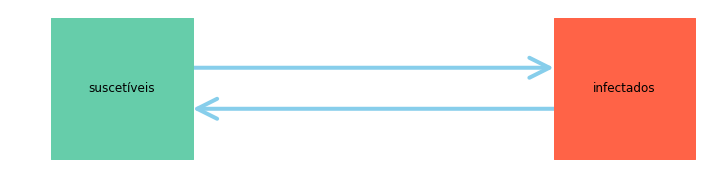

In [5]:
plt.figure(figsize=(12,3))

nx.draw_networkx_nodes(mdg_sis, pos, node_size=20000, with_labels=True, node_shape='s', node_color=color_map)
nx.draw_networkx_labels(mdg_sis, pos, labels=labels, fontsize=24)
#nx.draw_networkx_edges(mdg_sis, pos, node_size=20000, with_labels=True, arrowstyle='->', arrowsize=50, 
#                       edge_color='skyblue', width=4)
#nx.draw_networkx_edge_labels(mdg_sis, pos_for_right_edges, edge_labels, font_size=16)

nx.draw_networkx_edges(mdg_sis, pos_for_right_edges, edgelist=[(1,2)], node_size=20000, with_labels=True, arrowstyle='->', arrowsize=50, 
                       edge_color='skyblue', width=4)
nx.draw_networkx_edges(mdg_sis, pos_for_left_edges, edgelist=[(2,1)], node_size=20000, with_labels=True, arrowstyle='->', arrowsize=50, 
                       edge_color='skyblue', width=4)

#nx.draw_networkx_edge_labels(mdg_sis, {1:pos_for_right_edges[1]}, {(1,2,0):edge_labels[(1,2,0)]}, font_size=16)
plt.axis('off')
plt.show()

### Representação do modelo SIS na forma de ação de massas

Processos:

$$
\begin{cases}
  S + I \stackrel{\beta}{\rightarrow} 2I, & \text{(processo de infeção)} \\
  I \stackrel{\gamma}{\rightarrow} S, & \text{(processo de recuperação)}.
\end{cases}
$$

### Sistema de equações diferenciais para as densidades de população

Com $S+I = N$ (constante), $s = S/N$ e $i=I/N$, temos

$$ 
  \begin{cases}
    \displaystyle \frac{\rm d s}{\rm d t} =  -\beta is + \gamma i, \\
    \displaystyle \frac{\rm d i}{\rm d t} =  \beta is - \gamma i. \\
  \end{cases}
$$

#### Redução para uma equação diferencial

Como $s + i = 1$, temos

$$ \frac{\rm d i}{\rm d t} = \beta (1-i)i - \gamma i = (\beta - \gamma - \beta i) i =(\beta - \gamma) i - \beta i^2
$$

**Pontos fixos:** $i=0$ e $i=(\beta-\gamma)/\beta$.

Se $\beta>\gamma$ e $i(0)=i_0>0$, então
$$ \lim_{t\rightarrow \infty} i(t) = \frac{\beta-\gamma}{\beta}, \quad \text{e} \quad \lim_{t\rightarrow \infty} s(t) = \frac{\gamma}{\beta} 
$$

#### Condição para epidemia

Olhando para

$$\frac{\rm d i}{\rm d t} = (\beta - \gamma - \beta i) i,
$$

vemos que $i(t)$ cresce com $t$ quando $\beta - \gamma - \beta i >0$. Portanto, em termos dos parâmetros e da condição inicial $i(0)=i_0$, temos

$$ \textbf{Situação de Epidemia} \quad \Longleftrightarrow \quad  0 < i_0 < \frac{\beta - \gamma}{\beta}
$$

### Implementação da resolução do sistema de equações diferenciais

Em termos da população total $I$ de infectados e da população total $N = S + I$, temos

$$ \frac{\rm d I}{\rm d t} =  \beta \frac{I}{N}(N-I) - \gamma I.
$$

#### Parâmetros e dados iniciais

In [6]:
# população total
N = 100

# população inicial em no compartimento de infectados
I0 = 10 # infectados

# parâmetros
beta = 0.6 # fator de transmissão
gamma = 0.4 # fator de recuperação

#### Função taxa de evolução

In [7]:
def taxa_de_evolucao(I, t, N, beta, gamma):
    dIdt = (beta*(1 - I/N) - gamma)*I
    return dIdt

#### Resolvendo o sistema

In [8]:
t = np.linspace(0, 100, 101)
I = odeint(taxa_de_evolucao, I0, t, args=(N, beta, gamma))
S = N*np.ones_like(I) - I

#### Gráfico da evolução de cada compartimento

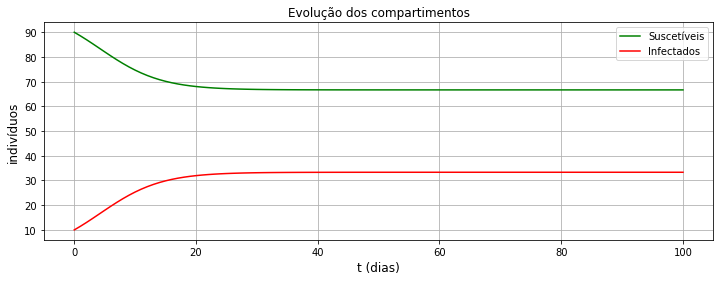

In [9]:
plt.figure(figsize=(12,4))
plt.plot(t, S, 'g', label='Suscetíveis')
plt.plot(t, I, 'r', label='Infectados')
plt.legend(loc='best')
plt.xlabel('t (dias)', fontsize=12)
plt.ylabel('indivíduos', fontsize=12)
plt.title('Evolução dos compartimentos')
plt.grid()
plt.show()

#### Verificando condição de epidemia

Para termos uma situação de epidemia, devemos ter 

$$ 0 < \frac{I_0 \beta}{(\beta-\gamma)N} < 1
$$

No exemplo, temos

In [10]:
I0*beta/(beta-gamma)/N

0.30000000000000004

## O modelo SI

Em outras doenças, o indivíduo infectado continua infectado pelo resto da vida e continua transmissor da doença. Um exemplo clássico é a *herpes*. Outro exemplo é o *HIV*.

O único parâmetro relevante é a **taxa de transmissão** $\beta$.

### Representação em forma de grafo:

In [11]:
gr_si = nx.DiGraph()
gr_si.add_node(1, compartimento='suscetíveis', node_color='mediumaquamarine')
gr_si.add_node(2, compartimento='infectados', node_color='tomato')
gr_si.add_edges_from([(1,2, {'taxa': r'$\beta \,i\,s$'})])

In [12]:
pos = {j: (j,0) for j in iter(gr_si.nodes)}
pos_for_edges = {j: (j, 0.1) for j in iter(gr_si.nodes)}
labels = {j: gr_si.node[j]['compartimento'] for j in iter(gr_si.nodes)}
edge_labels = {j: gr_si.edges[j]['taxa'] for j in iter(gr_si.edges)}
color_map = [gr_si.node[j]['node_color'] for j in iter(gr_si.nodes)]

#### Visualização do grafo

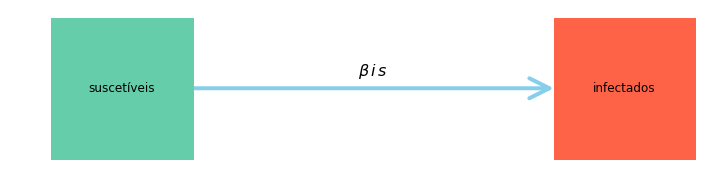

In [13]:
plt.figure(figsize=(12,3))

nx.draw_networkx_nodes(gr_si, pos, node_size=20000, node_shape='s', node_color=color_map)
nx.draw_networkx_labels(gr_si, pos, labels=labels, fontsize=24)
nx.draw_networkx_edges(gr_si, pos, node_size=20000, arrowstyle='->', arrowsize=50, 
                       edge_color='skyblue', width=4)
nx.draw_networkx_edge_labels(gr_si, pos_for_edges, edge_labels, font_size=16)
plt.axis('off')
plt.show()

### Representação do modelo SI na forma de ação de massas

Processo:

$$
  S + I \stackrel{\beta}{\rightarrow} 2I. \quad \text{(processo de infeção)}
$$

## O modelo SIS com vitalidade

Neste caso, nascimentos e mortes são consideradas. No caso mais simples, assume-se que

- Os **recém-nascidos** nascem suscetíveis a uma taxa de crescimento específico $\nu$

- As **mortes** são igualmente proporcionais em todos os compartimentos, a uma taxa de mortalidade específica $\mu$.

### Representação do modelo na forma de ação de massas

$$
\begin{cases}
  N \stackrel{\nu}{\rightarrow} S, & \text{(nascimento entre a população total)} \\
  S + I \stackrel{\beta}{\rightarrow} 2I, & \text{(processo de infeção)} \\
  I \stackrel{\gamma}{\rightarrow} S, & \text{(processo de recuperação)} \\
  S \stackrel{\mu}{\rightarrow} M, & \text{(mortalidade entre os suscetíveis)} \\
  I \stackrel{\mu}{\rightarrow} M, & \text{(mortalidade entre os infectados)}
\end{cases}
$$

### Equações diferenciais

Como $S$ e $I$ não dependem de $M$, podemos modelar apenas essas duas primeiras variáveis. A população viva é dada por $S+I = N$. O sistema de equações diferenciais é dado por

$$ 
  \begin{cases}
    \displaystyle \frac{\rm d S}{\rm d t} =  \nu N - \beta \frac{I}{N}S + \gamma I - \mu S, \\
    \displaystyle \frac{\rm d I}{\rm d t} =  \beta \frac{I}{N}S - \gamma I - \mu I. \\
  \end{cases}
$$



### População constante

Em períodos relativamente não muito longos de tempo, é razoável considerarmos uma população constante, o que é equivalente a considerar as taxas $\nu$ e $\mu$ iguais. 

Observe que

$$ \frac{\rm d}{\rm d t} (S + I) = \nu N - \mu (S + I).
$$

Se $\mu=\nu$, temos 

$$ \frac{\rm d}{\rm d t} (S + I) = \nu (N - S - I),
$$

de forma que $S+I = N$ constante é um ponto fixo do sistema.

## Outros modelos

- **SEIR**, onde E=*exposto*, que já foi infectado mas ainda não é contagioso, para doenças com um longo tempo de incubação, e um novo parâmetro de **latência**:

$$\rm S \rightarrow \rm E \rightarrow \rm I \rightarrow \rm R.
$$

- **SEIS**, onde E=*exposto*: 

$$\rm S \rightarrow \rm E \rightarrow \rm I \rightarrow \rm S.
$$

- **SICR** onde C=*portador*, em que alguns infectados não se tornam recuperados e carregam o vírus pela vida toda, como no caso da *tuberculose*. Os portadores podem, por vezes, voltar a desenvolver os sintomas e se tornar contagioso, passando ao compartimento de infectados, para em seguida retornar ao estado latente:

$$\rm S \rightarrow \rm I \rightarrow \rm R, \qquad \rm I \leftrightarrow \rm C.
$$

- **MSEIR**, onde M=*imunidade temporária de recém-nascido* ("maternally-derived immunity"), como em *sarampo*:

$$\rm M \rightarrow \rm S \rightarrow \rm I \rightarrow \rm R.
$$

- **MSEIRS**, com os recuperados tendo imunidade apenas temporária:

$$\rm M \rightarrow \rm S \rightarrow \rm I \rightarrow \rm R \rightarrow \rm S.
$$

## Taxa nominal de infecção com saturação

Em situações de uma alta proporção de infectados, levando em consideração questões de aglomeração dos infectados e medidas preventivas dos suscetíveis, foram propostas modificações na taxas nominal de infecção, substituindo o termo $\beta is$ por

$$ \beta \frac{s i^p}{1 + ki^q}
$$

com $p, q, k>0$.

## Modelo SIR com vitalidade e vacinação

Há vários modelos incluindo estratégias de vacinação. Vamos considerar um modelo simples, proposto em W. H. Herbert, "The mathematics of infectious diseases"; *SIAM Rev.* 42(200), 599–653, e discutido, com obtenção de controle ótimo, em G. Zaman, Y. H. Kang, I. H. Jung, "Stability analysis and optimal vaccination of an SIR epidemic model"; *Biosystems*, 93 (2008), 240-249.

Neste caso, a população de indivíduos suscetíveis, em um modelo SIR com vitalidade, é imunizada a uma taxa específica $u$, levando a um sistema de processos

$$ \begin{cases}
     \rm N \stackrel{\nu}{\rightarrow} \rm S \stackrel{\beta I/N}{\rightarrow} \rm I \stackrel{\gamma}{\rightarrow} \rm R, & \text{(natalidade, infecção, recuperação)} \\
     \rm S \stackrel{\nu}{\rightarrow} M, & \text{(mortalidade entre os suscetíveis)} \\ 
     \rm I \stackrel{\nu}{\rightarrow} M, & \text{(mortalidade entre os infectados)} \\
     \rm R \stackrel{\nu}{\rightarrow} M, & \text{(mortalidade entre os recuperados)} \\
     \rm S \stackrel{u}{\rightarrow} R, & \text{(imunização por vacinação dos suscetíveis)}
   \end{cases}
$$

onde $M$ é o número de **óbitos**, $N=S+I+R$ é a **população total**, que é constante, visto que a taxa de mortalidade é igual à taxa de natalidade $\nu$.

### Sistema de equações diferenciais do modelo

Sistema:

$$ 
  \begin{cases}
    \displaystyle \frac{\rm d S}{\rm d t} =  \nu N - \beta \frac{I}{N}S - u S - \nu S, \\
    \displaystyle \frac{\rm d I}{\rm d t} =  \beta \frac{I}{N}S - \gamma I - \nu I, \\
    \displaystyle \frac{\rm d R}{\rm d t} = \gamma I + u S - \nu R
  \end{cases}
$$


### Otimização da processo de vacinação

Considerando uma doença não muito grave, que não cause óbitos e onde o principal dano para a população como um todo seja a perda de produtividade, pode-se tentar estimar esse custo e equilibrar com o custo de vacinação para implementar uma política de vacinação que minimize o custo total. Isso nos leva a um problema de minimização de uma função custo.

A função custo proposta em Zaman, Kang & Jung (2008) tem a forma

$$ J(u) = \int_0^T \left( A_1 S(t) + A_2 I(t) + \frac{\tau}{2}u(t)^2\right) \;\rm dt,
$$
onde $A_1$ e $A_2$ são parâmetros de "custo por indivíduo", das populações de suscetíveis e infectados, por conta de medidas de prevenção e da infecção, e $\tau$ é um fator de custo da vacinação.

O objetivo é encontrar uma função $u=u(t)$ que minimize $J(u)$, i.e.

$$ \min_{u\in \mathcal U} J(u),
$$

onde $\mathcal U$ é um **espaço de funções admissíveis**.

## Exercícios

1. Faça uma análise do sistema de equações diferenciais do modelo **SIS com vitalidade e população constante** e resolva numericamente o sistema em casos típicos (com e sem epidemia)

1. Escreva as equações diferenciais dos modelos descritos na seção de **Outros modelos**.

1. Analise o sistema de equações diferenciais do modelo **SIR com vitalidade, população constante e vacinação**


---

### Apresentação em slides

Para visualizar na forma de slides, abrir um "terminal" *bash* e usar a linha de comando
```bash
jupyter nbconvert 11.00-Aula11.ipynb --to slides --post serve
```

Se quiser adicionar a possibilidade de rolar a página, caso algum *slide* seja muito longo, incluir a opção
```bash
--SlidesExporter.reveal_scroll=True
```

Para usar um tema diferente do padrão, temos a configuração via `SlidesExporter.reveal_theme`. Os temas disponíveis são `beige`, `black`, `blood`, `league`, `moon`, `night`, `serif`, `simple`, `sky`, `solarized`, `white`. O padrão é `white`. Um tema interessante é
```bash
--SlidesExporter.reveal_theme=solarized
```

Para usar um efeito de transição diferente do padrão, temos a configuração via `SlidesExporter.reveal_transition`. As opções são `none`, `fade`, `slide`, `convex`, `concave` e `zoom`. O padrão é `slide`. Uma transição interessante é 
```bash
--SlidesExporter.reveal_transition=convex
```

Mais informações sobre o `nbconvert` em [Configuration options (for nbconvert)](https://nbconvert.readthedocs.io/en/latest/config_options.html) e [Present Your Data Science Projects with Jupyter Notebook Slides!](https://medium.com/learning-machine-learning/present-your-data-science-projects-with-jupyter-slides-75f20735eb0f)

In [15]:
!jupyter nbconvert 12.00-Aula12.ipynb --to slides --SlidesExporter.reveal_scroll=True

[NbConvertApp] Converting notebook 12.00-Aula12.ipynb to slides
[NbConvertApp] Writing 359735 bytes to 12.00-Aula12.slides.html


<!--NAVIGATOR-->

---
[<- Aula 11: Epidemiologia - tipos de modelos, o modelo SIR compartimental e o modelo SIR individual](11.00-Aula11.ipynb) | [Página Inicial](00-Sumario.ipynb) | [Projeto 3: Controle de epidemia via vacinação ->](12.05-Projeto3.ipynb)

<a href="https://colab.research.google.com/github/rmsrosa/modelagem_matematica/blob/master/aulas/12.00-Aula12.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

<a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/master?filepath=aulas/12.00-Aula12.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open and Execute in Binder"></a>

<a href="https://rmsrosa.github.io/modelagem_matematica/aulas/12.00-Aula12.slides.html"><img align="left" src="https://rmsrosa.github.io/jupyterbookmaker/badges/slides_badge.svg" alt="Open slides" title="Open and View Slides"></a>
&nbsp;